In [1]:

import time
start=time.time()

import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
   

    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
 

    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    =
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

       
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):


    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):


    
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    
    for iter in range(max_iter):

        
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        
        if iter == 100:
            P = P / 4.
    print(Y)
    
    return Y


if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    X = np.loadtxt("mnist2500_X.txt")
    labels = np.loadtxt("mnist2500_labels.txt")
    Y = tsne(X, 2, 50, 20.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()
    end=time.time()
    print("time is --")
    print(end-start)


Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.386597
Iteration 10: error is 23.706233
Iteration 20: error is 21.214894
Iteration 30: error is 18.074480
Iteration 40: error is 16.995407
Iteration 50: error is 16.603288
Iteration 60: error is 16.393750
Iteration 70: error is 16.298786
Iteration 80: error is 16.204438
Iteration 90: error is 16.141042
Iteration 100: error is 16.091274
Iteration 110: error is 2.337964
Iteration 120: error is 2.088616
Iteration 130: error is 1.902980
Iteration 140: error is 1.764540
Iteration 150: error is 1.658137
Iteration 160: error is 1.574946
Iteration 170: error is 1.508740
It

time is --
1678.0926492214203


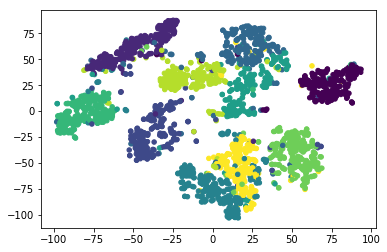

time is
<module 'time' (built-in)>


In [11]:
pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
pylab.show()
print("time is")
print(time)

In [2]:
import numpy as np
X = np.loadtxt("mnist2500_X.txt")
X.shape


(2500, 784)

In [14]:
import time
start=time.time()
end=time.time()
fin=end-start
print("time is { }",fin)


time is { } 8.273124694824219e-05
